In [1]:
import os
DIR = "PyTsetlinMachineCUDA_local"
#DIR = "PyTsetlinMachineCUDA_Jivitesh"
if DIR in os.listdir("."): os.chdir(DIR)
os.listdir(".")

['PyTsetlinMachineCUDA',
 'docs',
 'tm_y_vals.npy',
 '.ipynb_checkpoints',
 'LICENSE',
 'tm_predictions.npy',
 'setup.py',
 'examples',
 'Stats',
 'README.md']

In [2]:
import pandas as pd
import numpy as np
import math
HnM_DATA_PATH = "../../TsetlinMachine/HnM"
LATENT_FEATURE_NUM = 5

factor_names = [f"factor_{i}" for i in range(5)]
customers_df = pd.read_csv(f'{HnM_DATA_PATH}/customers.csv')#, index_col=0)
articles_df = pd.read_csv(f'{HnM_DATA_PATH}/articles.csv', dtype={"article_id": "str"})
uf_df = pd.read_csv(f"{HnM_DATA_PATH}/Matrix_Factors/HnM_User_Factor_Matrix.csv", dtype={0:object}, header=0, names=["customer_id"] + factor_names)
if_df = pd.read_csv(f"{HnM_DATA_PATH}/Matrix_Factors/HnM_Item_Factor_Matrix.csv", dtype={0:object}, header=0, names=["article_id"] + factor_names)

In [3]:
# Calculate weighted average of age to use as a default value
age_value_counts = customers_df["age"].value_counts()
weighted_average_age = np.floor(np.average(age_value_counts.index.to_numpy(), weights=age_value_counts.values))

customers_df.fillna({"FN":0., "Active":0., "club_member_status":"Unknown", "age":weighted_average_age}, inplace=True)
customers_df["fashion_news_frequency"] = customers_df["fashion_news_frequency"].replace(["NONE"], value="None").fillna("None")
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,None,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,None,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,None,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,None,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [4]:

def string_to_list(string):
    # Stripping single quotation does not work on the end instance for whatever reason, but replace does. Look into this some other time maybe?
    cleaned_string = string.strip("[]").replace("'","").replace("\n", "")
    return cleaned_string.split(", ")

def string_to_list_of_floats(string):
    # Stripping single quotation does not work on the end instance for whatever reason, but replace does. Look into this some other time maybe?
    cleaned_string = string.strip("[]").replace("'","").replace("\n", "")
    return np.fromstring(cleaned_string, dtype=np.float16, sep=", ")

#transactions_df_30 = pd.read_csv(f'{HnM_DATA_PATH}/Narrowed_HnM/transactions_train_narrowed_Xy_30days_5(custom)items.csv', index_col=0, converters={"article_id_x":string_to_list, "article_id_y":string_to_list, "days_since_transaction_x":string_to_list_of_floats, "days_since_transaction_y":string_to_list_of_floats})
transactions_df_30 = pd.read_csv(f'{HnM_DATA_PATH}/Narrowed_HnM/transactions_train_HnM_Xy_30days_category_prediction.csv', index_col=0, converters={"article_id_x":string_to_list, "article_id_y":string_to_list, "timestamp_y":string_to_list_of_floats, "timestamp_x":string_to_list_of_floats, "y_product_type_name": string_to_list, "y_product_group_name": string_to_list, "y_colour_group_name": string_to_list, "y_department_name": string_to_list})


In [5]:
# Sanity check
def detect_transaction_length_mismatch(input_df):
    df_copy = input_df.copy()
    df_copy["lens_article_id_x"] = df_copy["article_id_x"].apply(len)
    df_copy["lens_timestamp_x"] = df_copy["timestamp_x"].apply(len)
    df_copy["len_diff_x"] = df_copy["lens_article_id_x"] - df_copy["lens_timestamp_x"]
    diff_array_x = df_copy["len_diff_x"].to_numpy().nonzero()

    df_copy["lens_article_id_y"] = df_copy["article_id_y"].apply(len)
    df_copy["lens_timestamp_y"] = df_copy["timestamp_y"].apply(len)
    df_copy["len_diff_y"] = df_copy["lens_article_id_y"] - df_copy["lens_timestamp_y"]
    diff_array_y = df_copy["len_diff_y"].to_numpy().nonzero()

    return df_copy, diff_array_x, diff_array_y

df_copy, diff_array_x, diff_array_y = detect_transaction_length_mismatch(transactions_df_30)
diff_array_x, diff_array_y

((array([], dtype=int64),), (array([], dtype=int64),))

A list of the possible Y values can be found below:

In [6]:
#calculate the volume of each discrete day span and transform the df. Day spans are just manually calculated in this case
from scipy.stats import binned_statistic
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

day_values_sorted = transactions_df_30["timestamp_x"].explode().value_counts().sort_index()
bin_stat, bin_edges, bin_assignment = binned_statistic(day_values_sorted.index, day_values_sorted.values, statistic="sum", bins=[31, 38, 68, 98, 280, day_values_sorted.index.max()])
print(bin_stat, bin_edges)

# Used a 'manual' one hot encoding. sklearn wasn't cooperating. Also, I'm tired.
def discretize_value(value, bin_edges):
    discrete_array = np.digitize(value, bin_edges) - 1
    one_hot_encoding = np.zeros((discrete_array.size, len(bin_edges)))
    one_hot_encoding[np.arange(discrete_array.size), discrete_array] = 1
    return one_hot_encoding

transactions_df_30["discrete_days_x"] = transactions_df_30["timestamp_x"].transform(lambda x: discretize_value(x, bin_edges))
days_columns = [f"age <{edge}" for edge in bin_edges]
transactions_df_30["discrete_days_x"]
# test_vals = days_oh_encoder.fit_transform(transactions_df_30["discrete_days_x"])
# test_vals
#transactions_df_30["discrete_days_x"].explode().value_counts()


[ 114967.  582541.  787625. 3020170. 7569109.] [ 31.  38.  68.  98. 280. 733.]


0          [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
2          [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0....
6          [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
13         [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
15         [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
                                 ...                        
1337361    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
1337384    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
1337386    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
1337398    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....
1337400    [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0....
Name: discrete_days_x, Length: 225741, dtype: object

In [7]:
from PyTsetlinMachineCUDA_local.PyTsetlinMachineCUDA.tools import Booleanizer

BITS_PER_FEATURE = 5

article_latent_Booleanizer = Booleanizer(max_bits_per_feature=BITS_PER_FEATURE)
article_latent_Booleanizer.fit(if_df[if_df.columns[1:6]])
if_df[[f"latent_{i // BITS_PER_FEATURE}_{i % BITS_PER_FEATURE}" for i in list(range(BITS_PER_FEATURE * LATENT_FEATURE_NUM))]] = article_latent_Booleanizer.transform(if_df[if_df.columns[1:]])
articles_dict = {row[0]:np.asarray(row[LATENT_FEATURE_NUM + 1:], dtype=np.int16) for row in if_df.values}
articles_columns = if_df.columns[LATENT_FEATURE_NUM + 1:]
articles_dict

{'0108775015': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '0108775044': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '0108775051': array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1], dtype=int16),
 '0110065001': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '0110065002': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '0110065011': array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '0111565001': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int16),
 '0111565003': array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0], dtype=int16),
 '0111586001': array([1, 1, 1, 1, 1, 1, 

In [8]:
ind_article_columns = articles_columns.tolist() + days_columns
article_latent_and_days_column_names = [f"{art_col}" for art_col in ind_article_columns]
article_latent_and_days_column_names

['latent_0_0',
 'latent_0_1',
 'latent_0_2',
 'latent_0_3',
 'latent_0_4',
 'latent_1_0',
 'latent_1_1',
 'latent_1_2',
 'latent_1_3',
 'latent_1_4',
 'latent_2_0',
 'latent_2_1',
 'latent_2_2',
 'latent_2_3',
 'latent_2_4',
 'latent_3_0',
 'latent_3_1',
 'latent_3_2',
 'latent_3_3',
 'latent_3_4',
 'latent_4_0',
 'latent_4_1',
 'latent_4_2',
 'latent_4_3',
 'latent_4_4',
 'age <31.0',
 'age <38.0',
 'age <68.0',
 'age <98.0',
 'age <280.0',
 'age <733.0']

In [9]:
customer_latent_booleanizer = Booleanizer(max_bits_per_feature=BITS_PER_FEATURE)
customer_latent_booleanizer.fit(uf_df[uf_df.columns[1:]])
uf_df[[f"latent_{i // BITS_PER_FEATURE}_{i % BITS_PER_FEATURE}" for i in list(range(BITS_PER_FEATURE * LATENT_FEATURE_NUM))]] = customer_latent_booleanizer.transform(uf_df[uf_df.columns[1:]])
customers_dict = {row[0]:np.asarray(row[LATENT_FEATURE_NUM + 1:], dtype=np.int16) for row in uf_df.values}
customer_columns = uf_df.columns[LATENT_FEATURE_NUM + 1:]
customers_dict

{'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657': array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1], dtype=int16),
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa': array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=int16),
 '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e': array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0], dtype=int16),
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a': array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0], dtype=int16),
 '000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6': array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 

In [10]:
if_df.columns

Index(['article_id', 'factor_0', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'latent_0_0', 'latent_0_1', 'latent_0_2', 'latent_0_3',
       'latent_0_4', 'latent_1_0', 'latent_1_1', 'latent_1_2', 'latent_1_3',
       'latent_1_4', 'latent_2_0', 'latent_2_1', 'latent_2_2', 'latent_2_3',
       'latent_2_4', 'latent_3_0', 'latent_3_1', 'latent_3_2', 'latent_3_3',
       'latent_3_4', 'latent_4_0', 'latent_4_1', 'latent_4_2', 'latent_4_3',
       'latent_4_4'],
      dtype='object')

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
article_indexes = articles_df["article_id"].to_numpy().astype(str)
articles_used_cat_slice = articles_df.reset_index()[["product_type_name", "product_group_name", "index_group_name", "graphical_appearance_name", "section_name"]]#, "colour_group_code"]]#, "department_no", "section_no"]]


article_oh_encoder = OneHotEncoder()
article_oh_encoder.fit(articles_used_cat_slice)
articles_oh_encoded = article_oh_encoder.transform(articles_used_cat_slice).toarray().astype(np.int16)
#article_binary_dict = {article_id : articles_dict[article_id] for article_id, literals in zip(article_indexes, articles_oh_encoded)}
#article_cats_dict = {article_id:np.hstack((literals)) for article_id, *literals in zip(article_indexes, articles_oh_encoded)}
# for key in article_cats_dict:
#     article_cats_dict[key] = np.hstack((article_cats_dict[key], articles_dict[key]))
article_binary_dict = {article_id:np.hstack((np.asarray(literals, np.int16), articles_dict[article_id])) for article_id, literals in zip(article_indexes, articles_oh_encoded)}

In [12]:
print(article_binary_dict[next(iter(article_binary_dict.keys()))].shape)
#article_oh_encoder.categories_
article_cats_column_names = [f"{cat}_{val}" for cat, vals in zip(articles_used_cat_slice.columns, article_oh_encoder.categories_) for val in vals] + article_latent_and_days_column_names
len(article_cats_column_names)

(266,)


272

In [13]:
customer_ids = customers_df["customer_id"].to_numpy()
used_customer_cats = customers_df[["FN", "Active", "club_member_status", "age", "fashion_news_frequency"]].copy()

# Create discrete age categories
used_customer_cats["age"] = pd.qcut(used_customer_cats["age"], q=5, precision=0)
print(used_customer_cats.shape)
customer_oh_encoder = OneHotEncoder()
customer_oh_encoder.fit(used_customer_cats)
customers_binary = customer_oh_encoder.transform(used_customer_cats).toarray().astype(np.int16)
#customer_binary_dict = {customer_id : literals for customer_id, literals in zip(customer_ids, customers_binary)}
#customer_binary_dict = {customer_id : customers_dict[customer_id] for customer_id, literals in zip(customer_ids, customers_binary)}
customer_binary_dict = {customer_id : np.hstack((literals, customers_dict[customer_id])) for customer_id, literals in zip(customer_ids, customers_binary)}
customer_oh_encoder.categories_

(1371980, 5)


[array([0., 1.]),
 array([0., 1.]),
 array(['ACTIVE', 'LEFT CLUB', 'PRE-CREATE', 'Unknown'], dtype=object),
 array([Interval(15.0, 23.0, closed='right'),
        Interval(23.0, 28.0, closed='right'),
        Interval(28.0, 38.0, closed='right'),
        Interval(38.0, 51.0, closed='right'),
        Interval(51.0, 99.0, closed='right')], dtype=object),
 array(['Monthly', 'None', 'Regularly'], dtype=object)]

In [14]:
print(next(iter(customer_binary_dict.items()))[1].shape)
customer_cats_column_names = [f"{cat}_{val}" for cat, vals in zip(used_customer_cats.columns, customer_oh_encoder.categories_) for val in vals] + list(customer_columns)
customer_cats_column_names

(41,)


['FN_0.0',
 'FN_1.0',
 'Active_0.0',
 'Active_1.0',
 'club_member_status_ACTIVE',
 'club_member_status_LEFT CLUB',
 'club_member_status_PRE-CREATE',
 'club_member_status_Unknown',
 'age_(15.0, 23.0]',
 'age_(23.0, 28.0]',
 'age_(28.0, 38.0]',
 'age_(38.0, 51.0]',
 'age_(51.0, 99.0]',
 'fashion_news_frequency_Monthly',
 'fashion_news_frequency_None',
 'fashion_news_frequency_Regularly',
 'latent_0_0',
 'latent_0_1',
 'latent_0_2',
 'latent_0_3',
 'latent_0_4',
 'latent_1_0',
 'latent_1_1',
 'latent_1_2',
 'latent_1_3',
 'latent_1_4',
 'latent_2_0',
 'latent_2_1',
 'latent_2_2',
 'latent_2_3',
 'latent_2_4',
 'latent_3_0',
 'latent_3_1',
 'latent_3_2',
 'latent_3_3',
 'latent_3_4',
 'latent_4_0',
 'latent_4_1',
 'latent_4_2',
 'latent_4_3',
 'latent_4_4']

In [15]:
def x_vals_to_binary(customer_id, transactions, days_since_trans, padding, x_length=10):
    x_binary = customer_binary_dict[customer_id]
    transactions = transactions[:x_length]
    for trans, days in zip(transactions, days_since_trans):
        x_binary = np.concatenate((x_binary, np.concatenate((article_binary_dict[trans], days))))
    for _ in range(x_length - len(transactions)):
        x_binary = np.concatenate((x_binary, padding))
    return x_binary

def average_prescision_at_k(actual, predicted, k=10):
    if len(actual) == 0:
        return 0.0
    predicted = predicted[:,1]
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def naive_index_sorting(to_sort):
    indexed_list = [(val, index) for index, val in enumerate(to_sort)]
    indexed_list.sort(key=lambda x: x[0], reverse=True)
    return np.array(indexed_list)

def top_k_at_n(naive_sorting_method, y_vals, k=10):
    #sort x_vals according to highest rated index for each column
    #naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in x_vals])

    #Just reshape y_vals to ensure a list
    y_vals = y_vals.reshape((y_vals.shape[0], 1))
    apk_scores = np.array([average_prescision_at_k(item_y_vals, item_x_vals[:k], k) for item_y_vals, item_x_vals in zip(y_vals, naive_sorting_method)])

    return apk_scores.mean(), apk_scores

def calculate_accuracy(naive_sorting_method, y_vals):
    #naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in x_pred])
    top_predictions = naive_sorting_method[:,0,1]
    results = (top_predictions == y_vals)
    return results.mean(), results

In [17]:
# import nvidia_smi
#import gpustat
# #gpu_stats.print_json()
#
# nvidia_smi.nvmlInit()
# handle = nvidia_smi.nvmlDeviceGetHandleByIndex(2)
# handle_dict = {i:nvidia_smi.nvmlDeviceGetHandleByIndex(i) for i in range(3)}

to_gb = lambda x : x / (1000*1000)
# def get_device_memory(device_id):
#     gpu_stats = gpustat.GPUStatCollection.new_query()
#     info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle_dict[device_id])
#     t = to_gb(info.total)
#     u = to_gb(info.used)
#     f = to_gb(info.free)
#     return f"Total: {t}GB, Used: {u}GB, Free: {f}GB"

def print_all_device_memory():
    # gpu_stats = gpustat.GPUStatCollection.new_query()
    # gpu_stats.print_formatted()
    # all_devices = [get_device_memory(i) for i in range(3)]
    # print(all_devices)
    pass

def get_device_memory_tuple(device_id):
    # info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle_dict[device_id])
    # r = to_gb(info.total)
    # u = to_gb(info.used)
    # f = to_gb(info.free)
    #return (r, u, f)
    return (0, 0, 0)

print_all_device_memory()

In [ ]:
# Manually set CUDA device to something other than 0. When running the server seems to collect memory from orphaned processes
# Rendering it unable to train the TM on the original main GPU.
#os.environ["CUDA_DEVICE"] = "3"

In [23]:
from PyTsetlinMachineCUDA_local.PyTsetlinMachineCUDA.tm import MultiClassTsetlinMachine
#from PyTsetlinMachineCUDA_Jivitesh.PyTsetlinMachineCUDA.tm import MultiClassTsetlinMachine
from sklearn.model_selection import train_test_split
from time import time
from dataclasses import dataclass

def train_test_loop(X_train, X_test, Y_train, Y_test, tm):#tm_parameters):
    #tm = MultiClassTsetlinMachine(*tm_parameters)
    #accuracy_array = np.empty(0)
    loop_stats = []
    loop_start_time = time()
    print(f"\nAccuracy over {EPOCHS} epochs:\n")
    for i in range(EPOCHS):
        start_training = time()
        tm.fit(X_train, Y_train, epochs=1, incremental=True)
        stop_training = time()

        #print(tm.clause_weights)

        start_testing = time()
        prediction_score = tm.score(X_test)
        stop_testing = time()
        naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in prediction_score.transpose()])
        result_top_k, result_top_k_array = top_k_at_n(naive_sorting_method, Y_test, k=K_NUM)
        result_accuracy, result_accuracy_array = calculate_accuracy(naive_sorting_method, Y_test)

        epoch_stats = (i, float(result_accuracy), 0.0, float(result_top_k), time() - loop_start_time, stop_training - start_training, stop_testing - start_testing)
        loop_stats.append(epoch_stats)

        print(f"#{i + 1:d} Accuracy: {result_accuracy:.5f}% top_k_at_n: {result_top_k:.5f} Training: {stop_training - start_training:.2f}s Testing: {stop_testing - start_testing:.2f}s ")
    return loop_stats


exploded_ys_df = transactions_df_30["article_id_y"].explode()
y_value_counts = exploded_ys_df.value_counts()

@dataclass
class tm_config:
    number_of_clauses = 2#200
    T = 2#200
    s = 2
    max_weight = 1

EPOCHS = 10
# TM_PARAMETERS = [[5, 5, 5],[5, 5, 5],[5, 5, 5],[5, 5, 5]] #[40, 40, 5]
#Y_SUBSET_SIZE = [8, 64, 512, 2048]
Y_SUBSET_SIZE = [-1]
#TM_PARAMETERS = [[40, 40, 255, 16]] #[40, 40, 5]
#Y_SUBSET_SIZE = [400]
TRANSACTION_HISTORY_LENGTH = 10
#Y_SUBSET_SIZE =[-1]
#Y_SUBSET_SIZE = [8]

output_size_statistics = {}
for i, portion in enumerate(Y_SUBSET_SIZE):
    #if i > 0: break
    print_all_device_memory()
    output_size_statistics[portion] = get_device_memory_tuple(0)

    subset_time_start = time()
    trans_df = transactions_df_30.copy()
    unique_y_values = y_value_counts[:portion].index
    indexed_Y_vals_dict = {article_id:i for i, article_id in enumerate(unique_y_values)}

    # Restrict K_NUM from being larger than possible y values.
    K_NUM = 12
    K_NUM = K_NUM if K_NUM < len(unique_y_values) else len(unique_y_values)
    #transactions_binary = transactions_binary.merge(customers_df, on="customer_id", how="inner")
    arbitrary_X_shape = next(iter(article_binary_dict.values())).size + trans_df["discrete_days_x"][0][0].size
    padding_value = np.zeros(shape=arbitrary_X_shape)

    print(trans_df.shape)
    #Filter lists columns based on whether in top_items. Ensures that the age index matches the filtered item index
    trans_df["keep_indexes"] = trans_df["article_id_y"].apply(lambda x : [art_id in unique_y_values for art_id in x])
    trans_df["article_id_y"] = trans_df.apply(lambda x: np.array(x["article_id_y"])[x["keep_indexes"]], axis=1)
    trans_df["timestamp_y"] = trans_df.apply(lambda x: np.array(x["timestamp_y"])[x["keep_indexes"]], axis=1)
    trans_df = trans_df.drop(columns=["keep_indexes"], axis=0)
    trans_df = trans_df[trans_df["article_id_y"].map(len) > 0]
    print(trans_df.shape)

    trans_df["x_binary"] = trans_df.apply(lambda row: x_vals_to_binary(row["customer_id"], row["article_id_x"], row["discrete_days_x"], padding_value, x_length=TRANSACTION_HISTORY_LENGTH), axis=1)
    # transactions_binary["y_reduced"] = transactions_binary.apply(lambda row: indexed_Y_vals_dict[row["article_id_y"][-1]], axis=1)
    trans_df["y_reduced"] = trans_df.apply(lambda row: [indexed_Y_vals_dict[y] for y in set(row["article_id_y"])], axis=1)
    #trans_df = trans_df.explode("y_reduced")
    ind_article_columns = articles_columns.tolist() + days_columns
    input_columns = [f"c_{cus_col}" for cus_col in customer_columns] + [f"a{i}_{art_col}" for i in range(TRANSACTION_HISTORY_LENGTH) for art_col in ind_article_columns]

    print("Run stack data: ", unique_y_values.shape, trans_df.shape, (trans_df.shape[0] / 940816)*100)

    # X = np.stack(trans_df["x_binary"].values)
    # Y = trans_df["y_reduced"].to_numpy()
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    train_df, test_df = train_test_split(trans_df, test_size=0.2)
    print(train_df.shape, test_df.shape)
    train_df = train_df.explode("y_reduced")
    test_df = test_df.explode("y_reduced")

    X_train, X_test = np.stack(train_df["x_binary"].values), np.stack(test_df["x_binary"].values)
    Y_train, Y_test = train_df["y_reduced"].to_numpy(), test_df["y_reduced"].to_numpy()

    tm = MultiClassTsetlinMachine(number_of_clauses=tm_config.number_of_clauses, T=tm_config.T, s=tm_config.s, max_weight=tm_config.max_weight)


    output_size_statistics[portion] = train_test_loop(X_train, X_test, Y_train, Y_test, tm)#, TM_PARAMETERS[i])
    output_size_statistics[portion].append(("End: ", time() - subset_time_start, int(trans_df.size), int(unique_y_values.size), get_device_memory_tuple(0)))
    print(output_size_statistics)

(225741, 10)
(225741, 10)
Run stack data:  (28729,) (225741, 12) 23.994171017499703
(180592, 12) (45149, 12)

Accuracy over 10 epochs:



MemoryError: cuMemAlloc failed: out of memory

In [22]:
ind_article_columns = articles_columns.tolist() + days_columns
#input_columns = [f"c_{cus_col}" for cus_col in customer_columns] + [f"a{i}_{art_col}" for i in range(TRANSACTION_HISTORY_LENGTH) for art_col in ind_article_columns]
input_columns = [f"c_{cus_col}" for cus_col in customer_cats_column_names] + [f"a{i}_{art_col}" for i in range(TRANSACTION_HISTORY_LENGTH) for art_col in article_cats_column_names]
print(len(input_columns))
input_columns

2761


['c_FN_0.0',
 'c_FN_1.0',
 'c_Active_0.0',
 'c_Active_1.0',
 'c_club_member_status_ACTIVE',
 'c_club_member_status_LEFT CLUB',
 'c_club_member_status_PRE-CREATE',
 'c_club_member_status_Unknown',
 'c_age_(15.0, 23.0]',
 'c_age_(23.0, 28.0]',
 'c_age_(28.0, 38.0]',
 'c_age_(38.0, 51.0]',
 'c_age_(51.0, 99.0]',
 'c_fashion_news_frequency_Monthly',
 'c_fashion_news_frequency_None',
 'c_fashion_news_frequency_Regularly',
 'c_latent_0_0',
 'c_latent_0_1',
 'c_latent_0_2',
 'c_latent_0_3',
 'c_latent_0_4',
 'c_latent_1_0',
 'c_latent_1_1',
 'c_latent_1_2',
 'c_latent_1_3',
 'c_latent_1_4',
 'c_latent_2_0',
 'c_latent_2_1',
 'c_latent_2_2',
 'c_latent_2_3',
 'c_latent_2_4',
 'c_latent_3_0',
 'c_latent_3_1',
 'c_latent_3_2',
 'c_latent_3_3',
 'c_latent_3_4',
 'c_latent_4_0',
 'c_latent_4_1',
 'c_latent_4_2',
 'c_latent_4_3',
 'c_latent_4_4',
 'a0_product_type_name_Accessories set',
 'a0_product_type_name_Alice band',
 'a0_product_type_name_Baby Bib',
 'a0_product_type_name_Backpack',
 'a0_prod

In [21]:
import json

OUTPUT_DIR = "Stats"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
#json_stats = json.dumps(output_size_statistics)
with open(f"{OUTPUT_DIR}/TM_stats_{EPOCHS}_epochs_{'-'.join([str(y_sub) for y_sub in Y_SUBSET_SIZE])}_combined_full3.json", "w") as outfile:
    json.dump(output_size_statistics, outfile)

In [268]:
input_col_dict = {i:col for i, col in enumerate(input_columns)}

In [193]:
cat_array, count_array = np.unique(Y_train, return_counts=True)
np.vstack((cat_array, count_array))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
        83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199

In [220]:
test_df

,customer_id,article_id_x,timestamp_x,article_id_y,timestamp_y,y_product_type_name,y_product_group_name,y_colour_group_name,y_department_name,discrete_days_x,x_binary,y_reduced
1143982,daee058bc4a83343cd0d9140696216d1b011e81bd84fc1...,"[0747192007, 0436570033, 0824352001, 069659401...","[463.0, 297.0, 125.0, 125.0, 125.0, 125.0, 125.0]","[0562245046, 0706016003, 0706016001, 0706016001]","[13.0, 11.0, 11.0, 11.0]","[Trousers, Trousers, Trousers, Trousers, Trous...","[Garment Lower body, Garment Lower body, Garme...","[Black, Black, Dark Blue, Black, Black]","[Trouser, Trouser, Trousers, Trousers, Trousers]","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",4
99690,13167d78c8cc0851a09382669bc5b52bb0737799569ee0...,"[0637661001, 0687270001, 0573085010, 065168500...","[722.0, 722.0, 642.0, 642.0, 624.0, 624.0, 578...","[0919365008, 0891591007, 0827968021, 0871710001]","[20.0, 20.0, 20.0, 20.0]","[Trousers, Jacket, T-shirt, Shirt, Top, Top]","[Garment Lower body, Garment Upper body, Garme...","[Blue, Light Beige, Purple, Pink, White, Black]","[Trousers, Outwear, Jersey Basic, Tops Woven, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",117
535860,66999235bad63f34d5a83fea8cf81f7ed663397b39a45a...,"[0725332001, 0736651001, 0660308008, 069878600...","[578.0, 578.0, 535.0, 535.0, 535.0, 535.0, 535...","[0909916001, 0809238005]","[7.0, 7.0]","[Bra, Dress, Dress, Dress, Pyjama bottom, Legg...","[Underwear, Garment Full body, Garment Full bo...","[Off White, Yellow, Light Beige, Beige, Dark G...","[Loungewear, Blouse & Dress, Dress, Dress, Lou...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",217
4188,00cf15edd941b9ccbe71656b03c222e15cc6fe27089900...,"[0618480002, 0397068014, 0598841002, 061848000...","[729.0, 729.0, 729.0, 729.0, 729.0, 729.0, 729...","[0794321011, 0805000001, 0852584001, 0805000001]","[17.0, 17.0, 17.0, 14.0]","[Jacket, Hoodie, Outdoor trousers, Hoodie, Unk...","[Garment Upper body, Garment Upper body, Garme...","[Black, Light Pink, Black, Black, Black, Black]","[Ladies Sport Woven, Ladies Sport Bras, Ladies...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",170
1178384,e18a7f3ee1d87fb37eb9a4276e8c28908ec6374c2d35e8...,"[0621760005, 0621760005, 0689038001, 070835200...","[606.0, 606.0, 606.0, 606.0, 606.0, 606.0, 606...","[0867969003, 0867969003, 0706016001, 090991600...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 23....","[Pyjama bottom, Unknown, Unknown, Trousers, Tr...","[Nightwear, Unknown, Unknown, Garment Lower bo...","[Dark Green, Blue, Blue, Grey, Dark Blue, Dark...","[Loungewear, Denim Trousers, Denim Trousers, D...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",118
...,...,...,...,...,...,...,...,...,...,...,...,...
1093826,d15c136fd101b5dfbbfe3aae7165819fedbc9c8977fa3f...,"[0189616008, 0516741002, 0673911001, 062425700...","[730.0, 730.0, 730.0, 730.0, 730.0, 730.0, 730...","[0870328003, 0870328002, 0870328003, 082899100...","[17.0, 17.0, 8.0, 8.0, 8.0]","[Dress, Blouse, Skirt, Trousers, Skirt, Underw...","[Garment Full body, Garment Upper body, Garmen...","[Black, Turquoise, Black, Dark Blue, Pink, Bla...","[Jersey, Jersey, Skirts, OL Extended Sizes, Sk...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0....","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",168
988111,bd240bdf18bf89cedaf47300bd06d98fc06b784c01da42...,"[0676580002, 0657795007, 0732211001, 073210800...","[662.0, 662.0, 662.0, 591.0, 576.0, 576.0, 496...","[0803685001, 0804992017, 0865086006]","[21.0, 11.0, 11.0]","[T-shirt, Leggings/Tights, Unknown, Bra, T-shirt]","[Garment Upper body, Garment Lower body, Unkno...","[Light Pink, Black, Dark Pink, Pink, Black]","[Ladies Sport Bras, Ladies Sport Bottoms, Ladi...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0..

In [292]:
test_df_copy = test_df.copy()
#test_df_copy = test_df_copy.groupby("customer_id").aggregate("first")
#test_df_copy["y_reduced"] = test_df_copy.apply(lambda row: [indexed_Y_vals_dict[y] for y in set(row["article_id_y"])], axis=1)
#test_df_copy.sort_values("customer_id")
test_df_copy = test_df_copy.groupby("customer_id").aggregate({"x_binary": "first","y_reduced": lambda x: list(x)})
test_df_copy

,x_binary,y_reduced
customer_id,,
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[7, 335]"
0001b0127d3e5ff8dadcfc6e5043682dba2070f2667081623faeb31c996242a6,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[342, 208]"
00045027219e894b683fb4687211e2d0c904c268e9f28d370d9a84994678ac71,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",[143]
0005340aa69bb5a28d98712a36d8f669024bce137e3c82a618ea49032b9023c6,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",[124]
000e2ffc7b0ea9da547019bb0b1dc440bf59f6fcf2f190adbd715521951b4210,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",[160]
...,...,...
fff2021a309a979417359152629d2cde8c538c3a902fa3e3034b7bb38166f835,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[11, 32, 75]"
fff221aba935ab52c5aeda592994e298c8170b2656b0e52f19682479175fac6a,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[339, 31]"
fff9e830d0c21559ef730da1023cadb4c141597ad1e3669fbef1934c63810cab,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",[80]


In [301]:
X_test_agg = np.stack(test_df_copy["x_binary"].values)
Y_test_agg = test_df_copy["y_reduced"].to_numpy()
X_data_scores = tm.score(X_test_agg)

In [513]:
def average_prescision_at_k(actual, predicted, k=10):
    if len(actual) == 0:
        return 0.0
    #predicted = predicted[:,1]
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    score = score / min(len(actual), k)
    # if score != 0:
    #print(predicted, actual, score)
    return score

def naive_index_sorting(to_sort):
    indexed_list = [(val, index) for index, val in enumerate(to_sort)]
    indexed_list.sort(key=lambda x: x[0], reverse=True)
    return np.array(indexed_list)

def top_k_at_n(naive_sorting_method, y_vals, k=10):
    #sort x_vals according to highest rated index for each column
    #naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in x_vals])

    #Just reshape y_vals to ensure a list
    y_vals = y_vals.reshape((y_vals.shape[0], 1))
    apk_scores = np.array([average_prescision_at_k(item_y_vals, item_x_vals[:k], k) for item_y_vals, item_x_vals in zip(y_vals, naive_sorting_method)])

    return apk_scores.mean(), apk_scores

In [533]:
X_test_topk = np.stack(test_df["x_binary"].values)
Y_test_topk = test_df["y_reduced"].to_numpy()
X_scores_topk = tm.score(X_test_topk)
X_scores_topk

array([[ -21,   62,  -58, ...,   96,   96,   28],
       [  93,   47,   26, ...,   81,   81,   52],
       [ 100,  -48,  -23, ...,   18,   18,   23],
       ...,
       [  19, -100,  -93, ...,  -47,  -47, -100],
       [ -91,  -72,  -29, ...,  -41,  -41,  -15],
       [-100,  -31,  -40, ...,  -75,  -75,  -70]], dtype=int32)

In [534]:
topk_scores_argsorted = np.flip(X_scores_topk.argsort(axis=0)).transpose()
topk_scores_argsorted

array([[ 29,  36,   3, ..., 164,  23, 293],
       [ 10,  39,   0, ..., 206, 376, 303],
       [ 10,  39,   0, ..., 206, 376, 303],
       ...,
       [ 24,  62,   3, ...,  23, 152, 164],
       [ 28,   4,  23, ..., 363, 233, 297],
       [ 73,  63,   6, ..., 234, 228, 399]])

In [536]:
K = 12
#topk_results = np.array([average_prescision_at_k(actual, predicted[:K], K) for predicted, actual in zip(topk_scores_argsorted, Y_test_topk.reshape(-1, 1))])
topk_results = np.array([np.array((predicted[0], actual, predicted[0] == actual)) for predicted, actual in zip(topk_scores_argsorted, Y_test_topk)])
topk_results[:,2].mean()

0.0051153891210121444

In [448]:
sorted_topk = np.array([naive_index_sorting(x_pred_set) for x_pred_set in X_scores_topk.transpose()])
top_k_at_n(sorted_topk, Y_test_topk, 1)

[51] [51] 1.0
[4] [4] 1.0
[0] [0] 1.0
[0] [0] 1.0
[0] [0] 1.0
[57] [57] 1.0
[38] [38] 1.0
[55] [55] 1.0
[8] [8] 1.0
[0] [0] 1.0
[0] [0] 1.0
[5] [5] 1.0
[6] [6] 1.0
[18] [18] 1.0
[21] [21] 1.0
[123] [123] 1.0
[122] [122] 1.0
[0] [0] 1.0
[4] [4] 1.0
[0] [0] 1.0
[80] [80] 1.0
[4] [4] 1.0
[0] [0] 1.0
[33] [33] 1.0
[57] [57] 1.0
[7] [7] 1.0
[2] [2] 1.0
[4] [4] 1.0
[20] [20] 1.0
[2] [2] 1.0
[4] [4] 1.0
[4] [4] 1.0
[4] [4] 1.0
[2] [2] 1.0
[6] [6] 1.0
[1] [1] 1.0
[3] [3] 1.0
[0] [0] 1.0
[7] [7] 1.0
[7] [7] 1.0
[4] [4] 1.0
[0] [0] 1.0
[16] [16] 1.0
[2] [2] 1.0
[64] [64] 1.0
[1] [1] 1.0
[3] [3] 1.0
[5] [5] 1.0
[108] [108] 1.0
[0] [0] 1.0
[38] [38] 1.0
[5] [5] 1.0
[4] [4] 1.0
[4] [4] 1.0
[52] [52] 1.0
[4] [4] 1.0
[4] [4] 1.0
[0] [0] 1.0
[14] [14] 1.0
[3] [3] 1.0
[4] [4] 1.0
[7] [7] 1.0
[6] [6] 1.0
[0] [0] 1.0
[4] [4] 1.0
[206] [206] 1.0
[4] [4] 1.0
[7] [7] 1.0
[4] [4] 1.0
[2] [2] 1.0
[5] [5] 1.0
[1] [1] 1.0
[169] [169] 1.0
[4] [4] 1.0
[38] [38] 1.0
[5] [5] 1.0
[4] [4] 1.0
[4] [4] 1.0
[23] [23] 1.

(0.020676324729587255, array([0., 0., 0., ..., 0., 0., 0.]))

In [407]:
pred_sub = X_data_scores.transpose()
y_vals_sub = Y_test_agg
sorted = np.array([naive_index_sorting(x_pred_set) for x_pred_set in pred_sub])

In [337]:
top_k_at_n(sorted, y_vals_sub, 1)

[4] [4, 46, 152, 23] 1.0
[5] [26, 5, 74] 1.0
[0] [3, 0] 1.0
[4] [4, 201, 319, 216] 1.0
[1] [1, 39] 1.0
[1] [264, 1] 1.0
[33] [33] 1.0
[3] [3] 1.0
[5] [5] 1.0
[1] [346, 56, 1, 247] 1.0
[211] [211] 1.0
[4] [4, 46, 365, 20] 1.0
[0] [55, 250, 8, 0] 1.0
[5] [5] 1.0
[4] [4, 41, 303, 0] 1.0
[1] [323, 264, 1, 106, 15] 1.0
[1] [29, 277, 260, 1, 18, 181] 1.0
[0] [0] 1.0
[1] [1] 1.0
[4] [4, 121] 1.0
[3] [97, 3, 143] 1.0
[4] [4, 280, 80] 1.0
[4] [4, 251] 1.0
[3] [3] 1.0
[3] [3] 1.0
[23] [23, 80] 1.0
[152] [152, 293] 1.0
[0] [56, 94, 29, 0] 1.0
[7] [106, 7, 10, 34] 1.0
[3] [54, 206, 3, 55] 1.0
[10] [352, 10, 280, 77] 1.0
[2] [2, 14] 1.0
[23] [23, 160] 1.0
[0] [0] 1.0
[9] [9] 1.0
[2] [2] 1.0
[5] [5, 16] 1.0
[7] [225, 5, 40, 7, 160] 1.0
[5] [95, 5, 396] 1.0
[14] [14, 334] 1.0
[64] [64, 95, 371, 57, 312] 1.0
[1] [1, 247, 2] 1.0
[4] [4, 293] 1.0
[1] [4, 207, 1, 138] 1.0
[4] [4, 23] 1.0
[3] [3, 31] 1.0
[4] [89, 153, 35, 8, 68, 291, 4] 1.0
[4] [29, 207, 4, 160, 23, 101] 1.0
[4] [4] 1.0
[0] [189, 377, 248

(0.04248575784321592, array([0., 0., 0., ..., 0., 0., 0.]))

In [323]:
sorted[0][:,1]

array([ 10,  34,   7,  49,  52,  16, 188, 112, 211,  15,  21,  58,   2,
       311,  30,  96, 225,  44,  76,   1, 263,  20, 183,  66,  63, 298,
        22, 281,  24,  41,  12,  72,  14,  39,   6,  94, 102,   5, 218,
        51,  98, 118,  17,  84, 174, 178, 191,  33, 107, 114, 213, 309,
        47,  42,  56, 115, 108, 141,  71,  88, 109, 168,   3,  87, 342,
        67, 240,  68, 384, 121, 297, 344, 374,  85, 269,  74, 173, 237,
        31,  77,  83, 247,  59, 147, 116, 177, 244,  78, 198,  25,  40,
       126, 155,   8,  13, 199, 379,  89, 103, 128, 166,  93, 212, 135,
       175,  36, 110, 245,  75, 153, 200, 243, 322, 371,  28, 369,  11,
        19, 130, 149, 205,   9, 193, 302, 204, 249, 279, 285, 125, 182,
       252, 320, 375,  18,  43, 136,  69,  79,  86, 255,  70, 131, 137,
       167, 142, 146, 163, 398,   0, 124, 154, 181,  99, 186,  29,  48,
       292,  61, 328, 329, 338, 119, 231, 257, 270, 138, 185, 267, 236,
       370, 221, 306, 326,  60, 105, 253, 318, 106, 393, 397, 14

In [269]:
y_vals_sub.shape, X_data_scores.shape

((24926,), (400, 24926))

In [236]:
len(sorted)

41689

In [28]:
np.save("tm_predictions.npy",X_data_scores)
np.save("tm_y_vals.npy", Y)

In [34]:
X_data_scores_transposed = X_data_scores.transpose()
class_weighting = []
for i in range(X_data_scores_transposed.shape[1]):
    class_weighting.append(X_data_scores_transposed[:,i].sum())
np_class_weighting = np.vstack(class_weighting)
np.hstack((np_class_weighting, np_class_weighting.argsort(axis=0)[::-1]))

array([[  169285,        2],
       [ 1845241,       24],
       [ 5984677,        3],
       [ 4268861,        6],
       [-6171992,        8],
       [ 3749615,        5],
       [ 4172829,       34],
       [-2695002,       22],
       [ 3862363,       79],
       [ -311211,       13],
       [ 1987991,       14],
       [ 1692342,       71],
       [  188888,       16],
       [ 2651694,       68],
       [ 2650037,       17],
       [   74482,      124],
       [ 2551533,       74],
       [ 2494992,       26],
       [ 1504687,       10],
       [  729834,      100],
       [ 1788377,       67],
       [ 1292602,        1],
       [ 3063344,       61],
       [-5339086,       30],
       [ 4324743,       20],
       [ -853589,       28],
       [ 2009378,      102],
       [ -903032,       11],
       [ 1766320,       62],
       [ 1623578,       29],
       [ 1793310,       36],
       [-1065865,       18],
       [-3005434,       33],
       [ 1442253,       92],
       [ 31557

In [272]:
number_of_features = X[0].shape[0]
CLASS = 1
number_of_clauses = tm.number_of_clauses
included_features = []
excluded_features = []
included_features_negative = []
negated_features_negative = []

print(f"\nClass {CLASS} Positive Clauses:\n")
for j in range(0, number_of_clauses, 2):
    print("Clause #%d: " % (j), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.ta_action(CLASS, j, k) == 1:
            if k < number_of_features:
                #l.append(" x%d" % (k))
                l.append(f"x{input_col_dict[k]}")
                included_features.append((j, k))
            else:
                l.append("¬x%d" % (k-number_of_features))
                excluded_features.append((j, k))
    print(" ∧ ".join(l))

print(f"\nClass {CLASS} Negative Clauses:\n")
for j in range(1, number_of_clauses, 2):
    print("Clause #%d: " % (j), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.ta_action(CLASS, j, k) == 1:
            if k < number_of_features:
                l.append(" x%d" % (k))
                included_features_negative.append((j, k))
            else:
                l.append("¬x%d" % (k-number_of_features))
                negated_features_negative.append((j, k))
    print(" ∧ ".join(l))

print(len(included_features), len(excluded_features), len(included_features_negative), len(negated_features_negative))
# print("\nClass 1 Positive Clauses:\n")
# for j in range(0, 10, 2):
#     print("Clause #%d: " % (j), end=' ')
#     l = []
#     for k in range(number_of_features*2):
#         if tm.ta_action(1, j, k) == 1:
#             if k < number_of_features:
#                 l.append(" x%d" % (k))
#             else:
#                 l.append("¬x%d" % (k-number_of_features))
#     print(" ∧ ".join(l))
#
# print("\nClass 1 Negative Clauses:\n")
# for j in range(1, 10, 2):
#     print("Clause #%d: " % (j), end=' ')
#     l = []
#     for k in range(number_of_features*2):
#         if tm.ta_action(1, j, k) == 1:
#             if k < number_of_features:
#                 l.append(" x%d" % (k))
#             else:
#                 l.append("¬x%d" % (k-number_of_features))
#     print(" ∧ ".join(l))


Class 1 Positive Clauses:

Clause #0:  xa2_graphical_appearance_name_Solid ∧ xa4_latent_0_1 ∧ xa5_latent_0_0 ∧ xa6_latent_4_4 ∧ ¬x42 ∧ ¬x108 ∧ ¬x168 ∧ ¬x276 ∧ ¬x279 ∧ ¬x425 ∧ ¬x427 ∧ ¬x444 ∧ ¬x448 ∧ ¬x490 ∧ ¬x491 ∧ ¬x622 ∧ ¬x710 ∧ ¬x758 ∧ ¬x787 ∧ ¬x811 ∧ ¬x972 ∧ ¬x985 ∧ ¬x1142 ∧ ¬x1151 ∧ ¬x1175 ∧ ¬x1198 ∧ ¬x1200 ∧ ¬x1208 ∧ ¬x1253 ∧ ¬x1300 ∧ ¬x1303 ∧ ¬x1343 ∧ ¬x1425 ∧ ¬x1467 ∧ ¬x1536 ∧ ¬x1594 ∧ ¬x1683 ∧ ¬x1746 ∧ ¬x1761 ∧ ¬x1775 ∧ ¬x1828 ∧ ¬x1912 ∧ ¬x1986 ∧ ¬x2033 ∧ ¬x2044 ∧ ¬x2072 ∧ ¬x2122 ∧ ¬x2148 ∧ ¬x2319 ∧ ¬x2328 ∧ ¬x2333 ∧ ¬x2351 ∧ ¬x2374 ∧ ¬x2379 ∧ ¬x2445 ∧ ¬x2563 ∧ ¬x2662 ∧ ¬x2666 ∧ ¬x2704
Clause #2:  xc_latent_0_4 ∧ xc_latent_1_4 ∧ xa0_latent_3_4 ∧ ¬x123 ∧ ¬x262 ∧ ¬x358 ∧ ¬x393 ∧ ¬x422 ∧ ¬x425 ∧ ¬x454 ∧ ¬x482 ∧ ¬x521 ∧ ¬x532 ∧ ¬x877 ∧ ¬x983 ∧ ¬x1038 ∧ ¬x1152 ∧ ¬x1531 ∧ ¬x1682 ∧ ¬x1778 ∧ ¬x1787 ∧ ¬x1797 ∧ ¬x1803 ∧ ¬x1985 ∧ ¬x2001 ∧ ¬x2209 ∧ ¬x2296 ∧ ¬x2380 ∧ ¬x2541 ∧ ¬x2576 ∧ ¬x2590 ∧ ¬x2599 ∧ ¬x2611 ∧ ¬x2612 ∧ ¬x2654
Clause #4:  xa4_latent_0_3 ∧ xa6_index_group_name_Divided ∧ xa

In [421]:
for j in range(0, number_of_clauses, 2):
    print("Clause #%d: " % (j), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.ta_action(17, j, k) == 1:
            if k < number_of_features:
                l.append(f"x{input_col_dict[k]}")
            else:
                l.append("¬x%d" % (k-number_of_features))
    print(" ∧ ".join(l))

Clause #0:  xa1_product_type_name_Blouse ∧ xa4_section_name_Kids Local Relevance ∧ xa9_graphical_appearance_name_Jacquard ∧ ¬x1381
Clause #2:  xa1_section_name_Mama
Clause #4:  xa0_latent_1_0 ∧ xa2_index_group_name_Ladieswear ∧ xa3_latent_0_0 ∧ xa8_index_group_name_Ladieswear ∧ ¬x163 ∧ ¬x211 ∧ ¬x274 ∧ ¬x590 ∧ ¬x606 ∧ ¬x637 ∧ ¬x659 ∧ ¬x991 ∧ ¬x1030 ∧ ¬x1108 ∧ ¬x1239 ∧ ¬x1403 ∧ ¬x1432 ∧ ¬x1449 ∧ ¬x1479 ∧ ¬x1518 ∧ ¬x1626 ∧ ¬x2051 ∧ ¬x2141 ∧ ¬x2540 ∧ ¬x2558 ∧ ¬x2716
Clause #6:  ¬x293 ∧ ¬x294 ∧ ¬x1820 ∧ ¬x2422 ∧ ¬x2476
Clause #8:  xa1_latent_3_1 ∧ xa2_latent_1_3 ∧ xa3_latent_0_0 ∧ xa3_latent_3_2 ∧ xa9_latent_0_4 ∧ ¬x88 ∧ ¬x110 ∧ ¬x154 ∧ ¬x181 ∧ ¬x267 ∧ ¬x417 ∧ ¬x607 ∧ ¬x655 ∧ ¬x669 ∧ ¬x868 ∧ ¬x889 ∧ ¬x901 ∧ ¬x996 ∧ ¬x1039 ∧ ¬x1065 ∧ ¬x1120 ∧ ¬x1142 ∧ ¬x1161 ∧ ¬x1205 ∧ ¬x1343 ∧ ¬x1423 ∧ ¬x1488 ∧ ¬x1567 ∧ ¬x1584 ∧ ¬x1589 ∧ ¬x1666 ∧ ¬x1669 ∧ ¬x1701 ∧ ¬x1704 ∧ ¬x1796 ∧ ¬x1864 ∧ ¬x1869 ∧ ¬x1872 ∧ ¬x1878 ∧ ¬x1984 ∧ ¬x2053 ∧ ¬x2211 ∧ ¬x2251 ∧ ¬x2257 ∧ ¬x2316 ∧ ¬x2453 ∧ ¬x2505 ∧ ¬x2525
Clause #10: 

In [422]:
for j in range(0, number_of_clauses, 2):
    print("Clause #%d: " % (j), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.ta_action(110, j, k) == 1:
            if k < number_of_features:
                l.append(f"x{input_col_dict[k]}")
            else:
                l.append("¬x%d" % (k-number_of_features))
    print(" ∧ ".join(l))

Clause #0:  xa3_product_type_name_Sweater ∧ xa5_latent_1_0 ∧ ¬x65 ∧ ¬x453 ∧ ¬x2402
Clause #2:  xa4_product_type_name_Sandals
Clause #4:  xc_latent_0_4 ∧ xa1_product_group_name_Garment Upper body
Clause #6:  xa1_latent_2_4 ∧ xa9_product_type_name_Wallet
Clause #8:  xa6_index_group_name_Menswear
Clause #10:  xa6_product_type_name_Shirt
Clause #12:  xa6_section_name_Womens Everyday Collection ∧ ¬x2 ∧ ¬x81 ∧ ¬x174 ∧ ¬x835 ∧ ¬x1087 ∧ ¬x1212 ∧ ¬x1405 ∧ ¬x1714 ∧ ¬x2492
Clause #14:  xa4_latent_4_0 ∧ xa5_product_type_name_Polo shirt ∧ ¬x1105 ∧ ¬x1325 ∧ ¬x1844 ∧ ¬x1860 ∧ ¬x2635 ∧ ¬x2660
Clause #16:  xc_latent_0_2 ∧ xc_latent_3_1 ∧ xa7_latent_4_2 ∧ ¬x836 ∧ ¬x838 ∧ ¬x839 ∧ ¬x1011 ∧ ¬x1071 ∧ ¬x1137 ∧ ¬x1162 ∧ ¬x1544 ∧ ¬x1597 ∧ ¬x2145
Clause #18:  xa1_product_type_name_Blanket ∧ xa8_section_name_Womens Casual
Clause #20:  xa2_product_group_name_Garment Upper body ∧ xa7_product_group_name_Garment Upper body ∧ xa7_latent_4_1 ∧ ¬x1297
Clause #22:  xa0_latent_2_2 ∧ xa5_section_name_Womens Everyday Colle

In [426]:
X_test_agg[249]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(X_test_agg[249].reshape(1, -1), columns=input_columns))

,c_FN_0.0,c_FN_1.0,c_Active_0.0,c_Active_1.0,c_club_member_status_ACTIVE,c_club_member_status_LEFT CLUB,c_club_member_status_PRE-CREATE,c_club_member_status_Unknown,"c_age_(15.0, 23.0]","c_age_(23.0, 28.0]","c_age_(28.0, 38.0]","c_age_(38.0, 51.0]","c_age_(51.0, 99.0]",c_fashion_news_frequency_Monthly,c_fashion_news_frequency_None,c_fashion_news_frequency_Regularly,c_latent_0_0,c_latent_0_1,c_latent_0_2,c_latent_0_3,c_latent_0_4,c_latent_1_0,c_latent_1_1,c_latent_1_2,c_latent_1_3,c_latent_1_4,c_latent_2_0,c_latent_2_1,c_latent_2_2,c_latent_2_3,c_latent_2_4,c_latent_3_0,c_latent_3_1,c_latent_3_2,c_latent_3_3,c_latent_3_4,c_latent_4_0,c_latent_4_1,c_latent_4_2,c_latent_4_3,c_latent_4_4,a0_product_type_name_Accessories set,a0_product_type_name_Alice band,a0_product_type_name_Baby Bib,a0_product_type_name_Backpack,a0_product_type_name_Bag,a0_product_type_name_Ballerinas,a0_product_type_name_Beanie,a0_product_type_name_Belt,a0_product_type_name_Bikini top,a0_product_type_name_Blanket,a0_product_type_name_Blazer,a0_product_type_name_Blouse,a0_product_type_name_Bodysuit,a0_product_type_name_Bootie,a0_product_type_name_Boots,a0_product_type_name_Bra,a0_product_type_name_Bra extender,a0_product_type_name_Bracelet,a0_product_type_name_Braces,a0_product_type_name_Bucket hat,a0_product_type_name_Bumbag,a0_product_type_name_Cap,a0_product_type_name_Cap/peaked,a0_product_type_name_Cardigan,a0_product_type_name_Chem. cosmetics,a0_product_type_name_Clothing mist,a0_product_type_name_Coat,a0_product_type_name_Costumes,a0_product_type_name_Cross-body bag,a0_product_type_name_Cushion,a0_product_type_name_Dog Wear,a0_product_type_name_Dog wear,a0_product_type_name_Dress,a0_product_type_name_Dungarees,a0_product_type_name_Earring,a0_product_type_name_Earrings,a0_product_type_name_Eyeglasses,a0_product_type_name_Felt hat,a0_product_type_name_Fine cosmetics,a0_product_type_name_Flat shoe,a0_product_type_name_Flat shoes,a0_product_type_name_Flip flop,a0_product_type_name_Garment Set,a0_product_type_name_Giftbox,a0_product_type_name_Gloves,a0_product_type_name_Hair clip,a0_product_type_name_Hair string,a0_product_type_name_Hair ties,a0_product_type_name_Hair/alice band,a0_product_type_name_Hairband,a0_product_type_name_Hat/beanie,a0_product_type_name_Hat/brim,a0_product_type_name_Headband,a0_product_type_name_Heeled sandals,a0_product_type_name_Heels,a0_product_type_name_Hoodie,a0_product_type_name_Jacket,a0_product_type_name_Jumpsuit/Playsuit,a0_product_type_name_Keychain,a0_product_type_name_Kids Underwear top,a0_product_type_name_Leg warmers,a0_product_type_name_Leggings/Tights,a0_product_type_name_Long John,a0_product_type_name_Marker pen,a0_product_type_name_Mobile case,a0_product_type_name_Moccasins,a0_product_type_name_Necklace,a0_product_type_name_Night gown,a0_product_type_name_Nipple covers,a0_product_type_name_Other accessories,a0_product_type_name_Other shoe,a0_product_type_name_Outdoor Waistcoat,a0_product_type_name_Outdoor overall,a0_product_type_name_Outdoor trousers,a0_product_type_name_Polo shirt,a0_product_type_name_Pre-walkers,a0_product_type_name_Pumps,a0_product_type_name_Pyjama bottom,a0_product_type_name_Pyjama jumpsuit/playsuit,a0_product_type_name_Pyjama set,a0_product_type_name_Ring,a0_product_type_name_Robe,a0_product_type_name_Sandals,a0_product_type_name_Sarong,a0_product_type_name_Scarf,a0_product_type_name_Sewing kit,a0_product_type_name_Shirt,a0_product_type_name_Shorts,a0_product_type_name_Shoulder bag,a0_product_type_name_Side table,a0_product_type_name_Skirt,a0_product_type_name_Sleep Bag,a0_product_type_name_Sleeping sack,a0_product_type_name_Slippers,a0_product_type_name_Sneakers,a0_product_type_name_Socks,a0_product_type_name_Soft Toys,a0_product_type_name_Stain remover spray,a0_product_type_name_Straw hat,a0_product_type_name_Sunglasses,a0_product_type_name_Sweater,a0_product_type_name_Swimsuit,a0_product_type_name_Swimwear bottom,a0_product_type_name_Swimwear set,a0_product_type_name_Swimwear top,a0_product_type

In [427]:
input_col_dict

{0: 'c_FN_0.0',
 1: 'c_FN_1.0',
 2: 'c_Active_0.0',
 3: 'c_Active_1.0',
 4: 'c_club_member_status_ACTIVE',
 5: 'c_club_member_status_LEFT CLUB',
 6: 'c_club_member_status_PRE-CREATE',
 7: 'c_club_member_status_Unknown',
 8: 'c_age_(15.0, 23.0]',
 9: 'c_age_(23.0, 28.0]',
 10: 'c_age_(28.0, 38.0]',
 11: 'c_age_(38.0, 51.0]',
 12: 'c_age_(51.0, 99.0]',
 13: 'c_fashion_news_frequency_Monthly',
 14: 'c_fashion_news_frequency_None',
 15: 'c_fashion_news_frequency_Regularly',
 16: 'c_latent_0_0',
 17: 'c_latent_0_1',
 18: 'c_latent_0_2',
 19: 'c_latent_0_3',
 20: 'c_latent_0_4',
 21: 'c_latent_1_0',
 22: 'c_latent_1_1',
 23: 'c_latent_1_2',
 24: 'c_latent_1_3',
 25: 'c_latent_1_4',
 26: 'c_latent_2_0',
 27: 'c_latent_2_1',
 28: 'c_latent_2_2',
 29: 'c_latent_2_3',
 30: 'c_latent_2_4',
 31: 'c_latent_3_0',
 32: 'c_latent_3_1',
 33: 'c_latent_3_2',
 34: 'c_latent_3_3',
 35: 'c_latent_3_4',
 36: 'c_latent_4_0',
 37: 'c_latent_4_1',
 38: 'c_latent_4_2',
 39: 'c_latent_4_3',
 40: 'c_latent_4_4',


In [420]:
scores_transposed = X_data_scores.copy().transpose()
scores_argsort = scores_transposed.argsort()
scores_argsort[:,::-1]#scores_transposed#[:,::-1] # 249

array([[ 10,  34,  52, ..., 272, 340, 123],
       [  5,  52,   1, ..., 173, 264, 122],
       [  4,  80,  65, ..., 198, 184, 373],
       ...,
       [ 49,   4,  23, ...,  78, 373, 296],
       [ 42,  52, 119, ..., 180,  38, 292],
       [ 23,   4,  26, ..., 368, 216, 360]])

In [429]:
X_data_scores.transpose()[249]

array([ -36,   45,   22,   73, -100,   54,   37, -100,   36,   -8,   82,
         32,   51,   58,   30,   19,   -7,   92,   49,   25,   77,   18,
         18, -100,   85,  -24,   13, -100,   84,   17,   22,   13,  -75,
         20,   73,  -19,  -63, -100, -100,   40,   -9,   47,   71,   15,
         24,  -10,  -47,   22,   -6,   10,   -2,   61,   64,  -68,    0,
       -100,  -43,  -79,    8,  -47,  -18,   -1,   -7,   -2, -100,   20,
        -15,   12,   72,    0,  -27,  -57,    9,  -44,   32,  -34,  -30,
        -10,  -76,   -6, -100,    3,    8,   42,  -16,   -2,   17,  -14,
         49,    5,   21,   11,  -27,  -66,  -16,   -3,   59,  -79,    7,
        -21,  -65,  -29,  -98,  -37,   14,   -7,  -38,  -49,   79,   50,
         92,  -55,    3,  -14,  -14,  -13,   41,   14,   37,   -1, -100,
         70, -100,  -95,  -37,   -7,    1,  -14,    8,  -27,   45,  -13,
       -100,  -71,  -62,  -60,  -46,   -5,  -51,  -28,   17,   -5,   14,
         20,  -37,  -18,   54,  -43,   11,  -73,  -

In [126]:
np.hstack((np.array(input_columns), np.array(f"x{i}" for i in range(len(input_columns)))))

array(['c_FN_0.0', 'c_FN_1.0', 'c_Active_0.0', ..., 'a9_age <280.0',
       'a9_age <733.0', <generator object <genexpr> at 0x7f7cce098f20>],
      dtype=object)

In [170]:
clause_presence_dict = {}
for clause, feature in included_features:
    if feature in clause_presence_dict.keys():
        clause_presence_dict[feature] += 1
    else:
        clause_presence_dict[feature] = 1

clause_presence_dict
aranged_presence = np.zeros((1, len(input_columns)))
for key, value in clause_presence_dict.items():
    aranged_presence[0,key] = value
aranged_presence

array([[0., 0., 1., ..., 1., 0., 0.]])

In [355]:
presence_df = pd.DataFrame(np.vstack((aranged_presence,np.arange(len(input_columns)).reshape(1, -1))), columns=input_columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(presence_df.head())

c_FN_0.0  c_FN_1.0  c_Active_0.0  c_Active_1.0  \
0       0.0       0.0           1.0           1.0   
1       0.0       1.0           2.0           3.0   

   c_club_member_status_ACTIVE  c_club_member_status_LEFT CLUB  \
0                          1.0                             0.0   
1                          4.0                             5.0   

   c_club_member_status_PRE-CREATE  c_club_member_status_Unknown  \
0                              1.0                           0.0   
1                              6.0                           7.0   

   c_age_(15.0, 23.0]  c_age_(23.0, 28.0]  c_age_(28.0, 38.0]  \
0                 0.0                 0.0                 1.0   
1                 8.0                 9.0                10.0   

   c_age_(38.0, 51.0]  c_age_(51.0, 99.0]  c_fashion_news_frequency_Monthly  \
0                 3.0                 0.0                               0.0   
1                11.0                12.0                              13.0   

   c_fashion_news_frequency_None  c_fashion_news_frequency_Regularly  \
0                            1.0                                 1.0   
1                           14.0                                15.0   

   c_latent_0_0  c_latent_0_1  c_latent_0_2  c_latent_0_3  c_latent_0_4  \
0           3.0           3.0           1.0           6.0           4.0   
1          16.0          17.0          18.0          19.0          20.0   

   c_latent_1_0  c_latent_1_1  c_latent_1_2  c_latent_1_3  c_latent_1_4  \
0           6.0           2.0           5.0           2.0           1.0   
1          21.0          22.0          23.0          24.0          25.0   

   c_latent_2_0  c_latent_2_1  c_latent_2_2  c_latent_2_3  c_latent_2_4  \
0           1.0           0.0           0.0           0.0           0.0   
1          26.0          27.0          28.0          29.0          30.0   

   c_latent_3_0  c_latent_3_1  c_latent_3_2  c_latent_3_3  c_latent_3_4  \
0           1.0           2.0           0.0           1.0           1.0   
1          31.0          32.0          33.0          34.0          35.0   

   c_latent_4_0  c_latent_4_1  c_latent_4_2  c_latent_4_3  c_latent_4_4  \
0           0.0           0.0           0.0           0.0           0.0   
1          36.0          37.0          38.0          39.0          40.0   

   a0_product_type_name_Accessories set  a0_product_type_name_Alice band  \
0                                   0.0                              0.0   
1                                  41.0                             42.0   

   a0_product_type_name_Baby Bib  a0_product_type_name_Backpack  \
0                            0.0                            0.0   
1                           43.0                           44.0   

   a0_product_type_name_Bag  a0_product_type_name_Ballerinas  \
0                       0.0                              0.0   
1                      45.0                             46.0   

   a0_product_type_name_Beanie  a0_product_type_name_Belt  \
0                          0.0                        0.0   
1                         47.0                       48.0   

   a0_product_type_name_Bikini top  a0_product_type_name_Blanket  \
0                              0.0                           1.0   
1                             49.0                          50.0   

   a0_product_type_name_Blazer  a0_product_type_name_Blouse  \
0                          0.0                          0.0   
1                         51.0                         52.0   

   a0_product_type_name_Bodysuit  a0_product_type_name_Bootie  \
0                            0.0                          0.0   
1                           53.0                         54.0   

   a0_product_type_name_Boots  a0_product_type_name_Bra  \
0                         0.0                       0.0   
1                        55.0                      56.0   

   a0_product_type_name_Bra extender  a0_product_type_name_Bracelet  \
0         

In [353]:
CLASS = 22

all_literal_presence = {}
print(f"\nClass {CLASS} Positive Clauses:\n")
for c in range(tm.number_of_classes):
    print(f"Serching class nr.{c}")
    for j in range(0, number_of_clauses, 2):
        #print("Clause #%d: " % (j), end=' ')
        l = []
        for k in range(number_of_features*2):
            if tm.ta_action(c, j, k) == 1:
                if k < number_of_features:
                    if k not in all_literal_presence.keys():
                        all_literal_presence[k] = 1
                    else:
                        all_literal_presence[k] += 1
        #             l.append(f"x{input_col_dict[k]}")
        #         else:
        #             l.append("¬x%d" % (k-number_of_features))
        # print(" ∧ ".join(l))
all_literal_presence


Class 22 Positive Clauses:

Serching class nr.0
Serching class nr.1
Serching class nr.2
Serching class nr.3
Serching class nr.4
Serching class nr.5
Serching class nr.6
Serching class nr.7
Serching class nr.8
Serching class nr.9
Serching class nr.10
Serching class nr.11
Serching class nr.12
Serching class nr.13
Serching class nr.14
Serching class nr.15
Serching class nr.16
Serching class nr.17
Serching class nr.18
Serching class nr.19
Serching class nr.20
Serching class nr.21
Serching class nr.22
Serching class nr.23
Serching class nr.24
Serching class nr.25
Serching class nr.26
Serching class nr.27
Serching class nr.28
Serching class nr.29
Serching class nr.30
Serching class nr.31
Serching class nr.32
Serching class nr.33
Serching class nr.34
Serching class nr.35
Serching class nr.36
Serching class nr.37
Serching class nr.38
Serching class nr.39
Serching class nr.40
Serching class nr.41
Serching class nr.42
Serching class nr.43
Serching class nr.44
Serching class nr.45
Serching class 

{557: 164,
 827: 149,
 1485: 10,
 465: 141,
 2363: 33,
 9: 128,
 19: 285,
 1811: 94,
 39: 292,
 1281: 151,
 2474: 163,
 2680: 12,
 37: 304,
 855: 135,
 1375: 117,
 2397: 110,
 1118: 142,
 2464: 112,
 2477: 129,
 1110: 150,
 16: 227,
 20: 262,
 830: 144,
 1119: 122,
 2470: 139,
 2471: 101,
 450: 54,
 1114: 171,
 287: 128,
 1649: 86,
 14: 147,
 2362: 11,
 822: 28,
 1383: 124,
 2210: 80,
 575: 109,
 1654: 166,
 38: 317,
 1933: 147,
 2203: 141,
 568: 121,
 1112: 103,
 2306: 11,
 842: 178,
 1099: 161,
 1127: 159,
 1645: 168,
 1914: 159,
 1915: 149,
 2202: 146,
 2204: 150,
 2205: 153,
 2473: 131,
 2475: 167,
 2744: 91,
 1009: 148,
 1910: 29,
 2731: 172,
 564: 134,
 737: 147,
 849: 110,
 31: 293,
 836: 157,
 1652: 152,
 2222: 6,
 282: 167,
 1393: 106,
 2741: 126,
 65: 8,
 558: 150,
 2208: 106,
 2734: 134,
 34: 321,
 298: 165,
 846: 118,
 1384: 112,
 17: 212,
 33: 323,
 293: 162,
 295: 146,
 1267: 98,
 1662: 122,
 2186: 176,
 4: 177,
 1655: 132,
 2718: 44,
 1648: 108,
 466: 22,
 40: 222,
 1098

In [387]:
len(list(all_literal_presence.values()))

2761

In [391]:
all_literals_array = np.array(list(all_literal_presence.values()))
all_literals_array.mean()
# all_literals_array.sort()
# all_literals_array[::-1]

26.169865990583123

In [406]:
latent_boolean_indexes = np.array(["latent" in column_name for column_name in input_columns])
all_literals_array[~latent_boolean_indexes].mean(), all_literals_array[latent_boolean_indexes].mean()

(26.0, 27.705454545454547)

In [371]:
presence_df_all = pd.DataFrame(np.vstack((all_literals_array,np.arange(len(input_columns)).reshape(1, -1))), columns=input_columns)
presence_df_all.loc[2] = presence_df_all.iloc[0] / all_literals_array.sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(presence_df_all.head())

c_FN_0.0    c_FN_1.0  c_Active_0.0  c_Active_1.0  \
0  164.00000  149.000000     10.000000    141.000000   
1    0.00000    1.000000      2.000000      3.000000   
2    0.00227    0.002062      0.000138      0.001951   

   c_club_member_status_ACTIVE  c_club_member_status_LEFT CLUB  \
0                    33.000000                      128.000000   
1                     4.000000                        5.000000   
2                     0.000457                        0.001772   

   c_club_member_status_PRE-CREATE  c_club_member_status_Unknown  \
0                       285.000000                     94.000000   
1                         6.000000                      7.000000   
2                         0.003944                      0.001301   

   c_age_(15.0, 23.0]  c_age_(23.0, 28.0]  c_age_(28.0, 38.0]  \
0          292.000000           151.00000          163.000000   
1            8.000000             9.00000           10.000000   
2            0.004041             0.00209            0.002256   

   c_age_(38.0, 51.0]  c_age_(51.0, 99.0]  c_fashion_news_frequency_Monthly  \
0           12.000000          304.000000                        135.000000   
1           11.000000           12.000000                         13.000000   
2            0.000166            0.004207                          0.001868   

   c_fashion_news_frequency_None  c_fashion_news_frequency_Regularly  \
0                     117.000000                          110.000000   
1                      14.000000                           15.000000   
2                       0.001619                            0.001522   

   c_latent_0_0  c_latent_0_1  c_latent_0_2  c_latent_0_3  c_latent_0_4  \
0    142.000000     112.00000    129.000000    150.000000    227.000000   
1     16.000000      17.00000     18.000000     19.000000     20.000000   
2      0.001965       0.00155      0.001785      0.002076      0.003142   

   c_latent_1_0  c_latent_1_1  c_latent_1_2  c_latent_1_3  c_latent_1_4  \
0    262.000000    144.000000    122.000000    139.000000    101.000000   
1     21.000000     22.000000     23.000000     24.000000     25.000000   
2      0.003626      0.001993      0.001688      0.001924      0.001398   

   c_latent_2_0  c_latent_2_1  c_latent_2_2  c_latent_2_3  c_latent_2_4  \
0     54.000000    171.000000    128.000000      86.00000    147.000000   
1     26.000000     27.000000     28.000000      29.00000     30.000000   
2      0.000747      0.002367      0.001772       0.00119      0.002034   

   c_latent_3_0  c_latent_3_1  c_latent_3_2  c_latent_3_3  c_latent_3_4  \
0     11.000000     28.000000    124.000000     80.000000    109.000000   
1     31.000000     32.000000     33.000000     34.000000     35.000000   
2      0.000152      0.000388      0.001716      0.001107      0.001509   

   c_latent_4_0  c_latent_4_1  c_latent_4_2  c_latent_4_3  c_latent_4_4  \
0    166.000000    317.000000    147.000000    141.000000    121.000000   
1     36.000000     37.000000     38.000000     39.000000     40.000000   
2      0.002297      0.004387      0.002034      0.001951      0.001675   

   a0_product_type_name_Accessories set  a0_product_type_name_Alice band  \
0                            103.000000                        11.000000   
1                             41.000000                        42.000000   
2                              0.001426                         0.000152   

   a0_product_type_name_Baby Bib  a0_product_type_name_Backpack  \
0                     178.000000                     161.000000   
1                      43.000000                      44.000000   
2                       0.002463                       0.002228   

   a0_product_type_name_Bag  a0_product_type_name_Ballerinas  \
0                159.000000                       168.000000   
1                 45.000000                        46.000000   
2                  0.002201                         0.002325   

   a0_product_type_name_Beanie  a0_pro

In [139]:
test_preds = X_data_scores.copy()
test_preds.argsort(axis=0)[::-1]

array([[ 63,  63,  26, ...,  64, 276,   0],
       [213, 213, 333, ...,  10, 294,  15],
       [  7,   7, 335, ...,  38, 353,  82],
       ...,
       [235, 235, 327, ..., 104, 111,  55],
       [103, 103,  57, ...,  58, 164,  57],
       [223, 223, 284, ..., 305, 207, 273]])

In [137]:
test_preds[test_preds.argsort(axis=0)].shape

(400, 1000, 1000)

In [135]:
test_preds.sort(axis=0)
test_preds[::-1]

array([[ 40,  40,  40, ...,  40,  40,  40],
       [ 40,  40,  40, ...,  40,  33,  40],
       [ 40,  40,  40, ...,  40,  32,  40],
       ...,
       [-40, -40, -40, ..., -40, -40, -40],
       [-40, -40, -40, ..., -40, -40, -40],
       [-40, -40, -40, ..., -40, -40, -40]], dtype=int32)

In [121]:
# readable_columns = pd.DataFrame(np.array(input_columns).reshape(1, -1), columns=[f"x{i}" for i in range(len(input_columns))])
readable_columns = pd.DataFrame()
readable_columns

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2761 and the array at index 1 has size 1

In [29]:
clause_inclusion_single = np_included_features[np.where(np_included_features[:,0] == 4)]
np.apply_along_axis(lambda x: input_col_dict[x[1]], 1, clause_inclusion_single)

NameError: name 'input_col_dict' is not defined

In [336]:
clause_negation_single = np_excluded_features[np.where(np_excluded_features[:, 0] == 2)]
np.apply_along_axis(lambda x: input_col_dict[x[1] - len(input_col_dict)], 1, clause_negation_single)

array(['a7_age <68.0'], dtype='<U12')

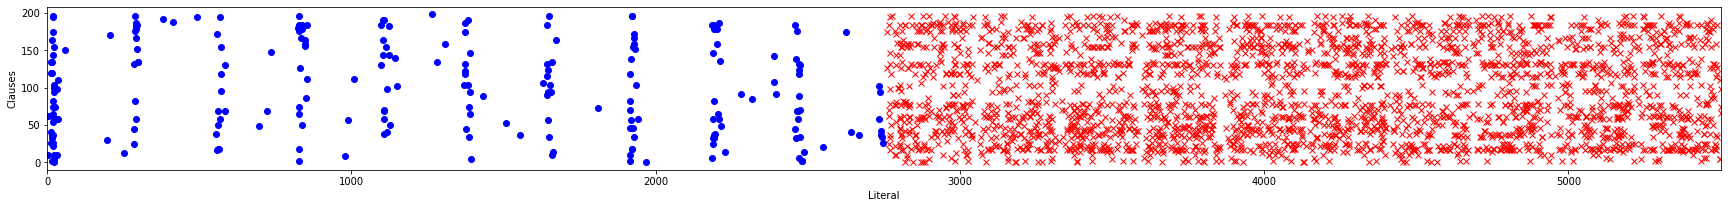

In [158]:
import matplotlib.pyplot as plt
np_included_features = np.vstack(included_features)
np_excluded_features = np.vstack(excluded_features)
figure = plt.figure(figsize=(30, 3), label=f"Included and negated {CLASS} positive clauses")
ax = figure.add_subplot()
ax.plot(np_included_features[:,1],np_included_features[:,0], "bo")
ax.plot(np_excluded_features[:,1],np_excluded_features[:,0], "rx")
#x_ticks = ax.get_xticks()
#x_ticks = np.delete(x_ticks, np.isin(x_ticks, [0.0, -1000]), axis=0)
#new_ticks = np.append(x_ticks, np_included_features[:,1])
#ax.set_xticks(new_ticks)
ax.set_xlim(0, np.max(np_excluded_features))
ax.set_ylabel("Clauses")
ax.set_xlabel("Literal")
#plt.set_xticks
plt.show()

In [338]:
import shap

def tm_model_call(model, data):
    return model.predict(data)

explainer = shap.Explainer(lambda x: tm_model_call(tm, x), X, feature_names=input_columns)

In [339]:
shap_values = explainer(X[:100], max_evals=3000)

Permutation explainer: 101it [1:21:20, 48.81s/it]                         


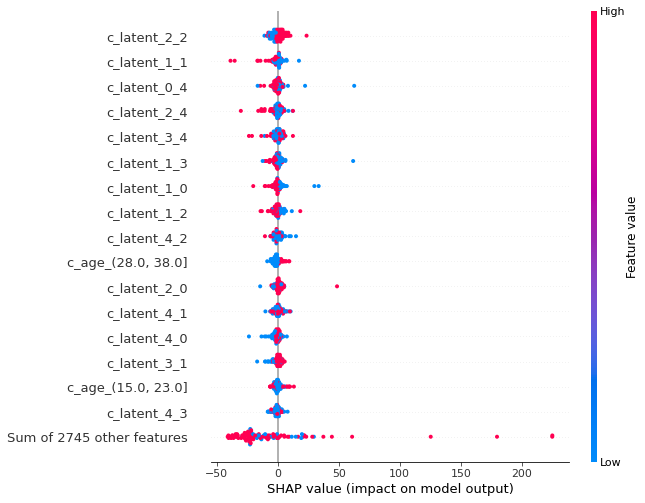

In [346]:
shap.plots.beeswarm(shap_values, max_display=17)

In [16]:
# tm = MultiClassTsetlinMachine(300, 200, 30)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# accuracy_array = np.empty(0)
# print("\nAccuracy over 250 epochs:\n")
# for i in range(15):
#     start_training = time()
#     tm.fit(X_train, Y_train, epochs=1, incremental=True)
#     stop_training = time()
#
#     start_testing = time()
#     prediction_score = tm.score(X_test)
#     naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in prediction_score.transpose()])
#     result_top_k, result_top_k_array = top_k_at_n(naive_sorting_method, Y_test, k=K_NUM)
#     result_accuracy, result_accuracy_array = calculate_accuracy(naive_sorting_method, Y_test)
#     stop_testing = time()
#     accuracy_array = np.append(accuracy_array, result_accuracy)
#
#     print(f"#{i + 1:d} Accuracy: {result_accuracy:.5f}% top_k_at_n: {result_top_k:.5f} Training: {stop_training - start_training:.2f}s Testing: {stop_testing - start_testing:.2f}s "
#           f"[max: {accuracy_array.max():.3f}%, min: {accuracy_array.min():.3f}%, std: {accuracy_array.std():.5f}]")
#
# accuracy_array

In [ ]:
test_value_counts = pd.DataFrame(Y_test).value_counts()
test_value_counts.max() / test_value_counts.sum()

In [147]:
from sklearn.metrics import confusion_matrix
CONFUSION_SUBSET_SIZE = -1
X_sub, y_sub = X_test[:CONFUSION_SUBSET_SIZE], Y_test[:CONFUSION_SUBSET_SIZE]
pred_sub = tm.score(X_sub)

In [155]:
y_sub

array([5, 0, 387, ..., 338, 351, 71], dtype=object)

In [156]:
predicted_cats = pred_sub.transpose().argmax(axis=1)
np.unique(predicted_cats, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184

In [154]:
confusion_matrix(predicted_cats, y_sub)

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [ ]:
#X_batch, Y_batch = X_test[:512], Y_test[:512]
#X_train_batch, X_test_batch, Y_train_batch, Y_test_batch = train_test_split(X, Y, test_size=0.2)
X_test_batch = np.stack(transactions_binary["x_binary"].values)#[:512]
Y_test_batch = transactions_binary["y_reduced"].to_numpy()#[:512]
prediction = tm.predict(X_test_batch)
prediction_score = tm.score(X_test_batch)
true_indexes = (tm.predict(X_test_batch) == Y_test_batch).nonzero()
print(prediction_score.shape)
print(prediction)
true_indexes

In [ ]:
prediction_value_counts = pd.DataFrame(prediction).value_counts()
prediction_value_counts.max() / prediction_value_counts.sum()

In [ ]:
len(true_indexes[0])
prediction_score.shape
true_prediction = prediction_score.transpose()[true_indexes]
true_prediction

In [ ]:
def average_prescision_at_k(actual, predicted, k=10):
    if len(actual) == 0:
             return 0.0
    predicted = predicted[:,1]
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    print(predicted.shape, predicted, actual, score)

    return score / min(len(actual), k)

def naive_index_sorting(to_sort):
    indexed_list = [(val, index) for index, val in enumerate(to_sort)]
    indexed_list.sort(key=lambda x: x[0], reverse=True)
    return np.array(indexed_list)

def top_k_at_n(x_vals, y_vals, k=10):
    #sort x_vals according to highest rated index for each column
    naive_sorting_method = np.array([naive_index_sorting(x_pred_set) for x_pred_set in x_vals])
    #print(naive_sorting_method[0])
    #x_vals_argmax = np.array([np.argsort(x_val_set, axis=0)[::-1] for x_val_set in x_vals])


    #x_vals_argmax = np.argsort(x_vals, axis=0)[::-1]
    #print(x_vals.shape, x_vals_argmax.shape)
    #print(x_vals_argmax[0].shape, x_vals[0], x_vals_argmax[0])
    #Just reshape y_vals to ensure a list
    y_vals = y_vals.reshape((y_vals.shape[0], 1))
    apk_scores = np.array([average_prescision_at_k(item_y_vals, item_x_vals[:k], k) for item_y_vals, item_x_vals in zip(y_vals, naive_sorting_method)])

    return apk_scores.mean(), apk_scores

#
# temp_score_transposed = prediction_score_transposed.copy()
# argsorted_prediction_scores = np.argsort(prediction_score, axis=0)[::-1]
# argsorted_prediction_scores[:, 0]
# Y_batch = Y_batch.reshape((Y_batch.shape[0], 1))
# Y_batch = Y_batch.reshape((Y_batch.shape[0], 1))
apk_score_mean, apk_score = top_k_at_n(prediction_score.transpose(), Y_test_batch)
apk_score_mean#, apk_score

In [ ]:
# def average_prescision_at_k(actual, predicted, k=10):
#     if len(actual) == 0:
#         return 0.0
#
#     score = 0.0
#     num_hits = 0.0
#
#     for i,p in enumerate(predicted):
#         if p in actual and p not in predicted[:i]:
#             num_hits += 1.0
#             score += num_hits / (i+1.0)
#
#     return score / min(len(actual), k)
#
# def top_k_at_n(x_vals, y_vals, k=10):
#     #sort x_vals according to highest rated index for each column
#     x_vals_argmax = np.argsort(x_vals, axis=0)[::-1]
#     #Just reshape y_vals to ensure a list
#     y_vals = y_vals.reshape((y_vals.shape[0], 1))
#     apk_scores = np.array([average_prescision_at_k(item_y_vals, item_x_vals[:k], k) for item_y_vals, item_x_vals in zip(y_vals, x_vals_argmax)])
#
#     return apk_scores.mean(), apk_scores
#
# #
# # temp_score_transposed = prediction_score_transposed.copy()
# # argsorted_prediction_scores = np.argsort(prediction_score, axis=0)[::-1]
# # argsorted_prediction_scores[:, 0]
# # Y_batch = Y_batch.reshape((Y_batch.shape[0], 1))
# # Y_batch = Y_batch.reshape((Y_batch.shape[0], 1))
# top_k_at_n(prediction_score, Y_test_batch)

In [ ]:
sorted_scores = np.sort(prediction_score_transposed[0])[::-1]
argsorted_scores = np.argsort(prediction_score_transposed[0])[::-1]
np.vstack((prediction_score_transposed[0][argsorted_scores], sorted_scores))
print((argsorted_scores == 264).nonzero())
argsorted_scores